In [1]:
import pydwf
import pydwf.utilities
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import butter, lfilter
import datetime

%matplotlib widget

## Helper functions

In [2]:
def generate_apesw(n_warmup: int, n_pulse: int):
    warmup = [*[1, 0] * n_warmup]
    switch = [1, 1, 0, 1, 0]
    return np.array([*((warmup + switch) * n_pulse) + warmup])

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

## Open device

In [4]:
## Open device
dwf = pydwf.DwfLibrary()
dev = dwf.deviceControl.open(-1)

## Setup output settings

In [5]:
## Analog output settings
outCH = [0, 1]
outData = generate_apesw(4, 3)
n_data = len(outData)
outFreq = 80e3 / n_data
outTRun = 1 / outFreq
outTWait = 0 / outFreq
outRepeat = 1

## Setup analogOut
anOut = dev.analogOut
node = pydwf.DwfAnalogOutNode.Carrier
for CH in outCH:
    anOut.reset(CH)
    anOut.nodeEnableSet(CH, node, True)
    anOut.nodeFunctionSet(CH, node, pydwf.DwfAnalogOutFunction.Custom)
    anOut.nodeFrequencySet(CH, node, outFreq)
    anOut.nodeAmplitudeSet(CH, node, 5)
    anOut.idleSet(CH, pydwf.DwfAnalogOutIdle.Disable)
    anOut.runSet(CH, outTRun)
    anOut.waitSet(CH, outTWait)
    anOut.repeatSet(CH, outRepeat)
    anOut.triggerSourceSet(CH, pydwf.DwfTriggerSource.PC)
anOut.nodeDataSet(outCH[0], node, outData)
anOut.nodeDataSet(outCH[1], node, 1 - outData)

## Setup input settings

In [126]:
## Analog input settings
inCH = [0, 1]
inFreq = 1e6
inRecordLen = 6 / outFreq  # 5 Times output signal length
inNSamples = int(inFreq * inRecordLen)

## Setup analogIn
anIn = dev.analogIn
anIn.reset()
for CH in inCH:
    anIn.channelEnableSet(CH, True)
anIn.acquisitionModeSet(pydwf.DwfAcquisitionMode.Record)
anIn.frequencySet(inFreq)
anIn.recordLengthSet(inRecordLen)
anIn.triggerSourceSet(pydwf.DwfTriggerSource.PC)
time.sleep(2)  # Sleep to allow offset to stabilize

## Read data

0
205.19%  8192      8464


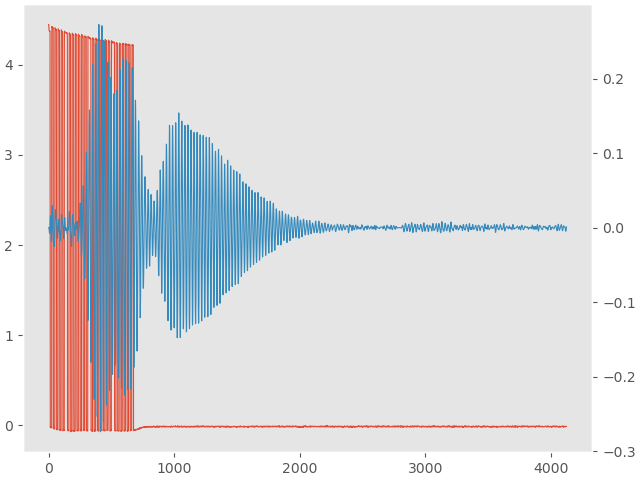

In [147]:
plt.close()
fig, axs = plt.subplots(1, 1, sharex=True)
axs = [axs]
runs = []

for i in range(1):
    print(i)
    
    ## Generate new APESW
    outData = generate_apesw(5+i, 3)
    n_data = len(outData)
    outFreq = 80e3 / n_data
    outTRun = 1 / outFreq
    outTWait = 0 / outFreq

    ## Setup output data
    for CH in outCH:
        anOut.nodeFrequencySet(CH, node, outFreq)
        anOut.runSet(CH, outTRun)
        anOut.waitSet(CH, outTWait)
    anOut.nodeDataSet(outCH[0], node, outData)
    anOut.nodeDataSet(outCH[1], node, 1 - outData)

    ## Start analogOut and analogIn
    anOut.configure(-1, 1)
    anIn.configure(True, True)
    dev.triggerPC()  # Send trigger signal

    ## Read data from analogIn
    samples = []
    while True:
        status = anIn.status(True)
        if status in [pydwf.DwfState.Armed, pydwf.DwfState.Ready]:
            continue
        aSamples, _, _ = anIn.statusRecord()

        if aSamples != 0:
            cSamples = np.vstack(
                        [anIn.statusData(idx, aSamples)
                         for idx in inCH]).transpose()
            samples.append(cSamples)
        
        nSamples = sum(len(x) for x in samples)
        print(f"\r\033[K{100*nSamples/inNSamples: >4.2f}% {aSamples: >5} {nSamples: >9}", end="")

        if status == pydwf.DwfState.Done and nSamples >= inNSamples:
            break
    print()

    ## Concatenate all sample chunks
    samples = np.concatenate(samples)

    ## Discard oldest samples
    samples = samples[-inNSamples:]

    inSig = samples[:, 0]
    outSig = butter_bandpass_filter(samples[:, 1], 20e3, 80e3, inFreq)
    # outSig = butter_bandpass_filter(samples[:, 1], 20e3, 250e3, inFreq)
    # outSig = samples[:, 1]

    axs[i].plot(inSig, c="C0")
    axr = axs[i].twinx()
    axr.plot(outSig, c="C1")
    axs[i].grid(False)
    axr.grid(False)

now = datetime.datetime.now()
# np.savetxt(f"data/data_full-bridge_{now:%y%m%d-%H%M%S}.csv", samples, delimiter=",")

## Close device

In [148]:
dev.close()